In [50]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [51]:
fishes = 4

In [96]:
class KNNFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    """
        kNN classifier determines the class of a data point by majority voting principle. 
        
        If k is set to n, the classes of n closest points are checked. 
        Prediction is done according to the majority class. 
        Similarly, kNN regression takes the mean value of n closest points.
    """
    def __init__(self, k):
        self.k = k
        
    
    def choose_action(self, view: np.ndarray):
    
        speed, turn = self.predict(view, self.k)
        
        turn = self.avoid_walls(view, turn)
        
        return speed, turn

    def avoid_walls(self, view, turn):
        
        if view[6] > 0.9:
            return 5 * np.pi
        else:
            return turn
                   
    
    def euclidean_distance(self, x_1, x_2):
        """
        Measures the distance between data points to determine how data points are close.
        Euclidean distance is used for distance measurement and it is calculated 
        using the square of the difference between x and y coordinates of the points.
        
        Parameters
        ---------
        x1, x2 : array_like
            Elements to find the distance between.
        
        Returns
        ---------
        distance : ndarray
            Distance scalar        
        """
        return np.sum((x_1-x_2)**2, axis = 1)
    
    def fit(self, dset):
        """        
        Storing the training set's speed for separate class predictions.
        """
        self.X = dset[:]["views"]
        self.y = dset[:]["actions"]
               
    
    def predict(self, view, k):
        
        """
        Predict the class of a data point by majority voting principle. 
        
        Parameters
        ---------
        X_test : array_like
            Test or created by TrackGeneratorGymRaycast datapoint
            
        k : int
            The number of k nearest neighbors to be used to determine a class of test datapoint
        
        Returns
        ---------
        predictions : list
            predicted speed/turn as the mean value of k closest points       
        """
        # getting distance for each prticular data point
        distances = self.euclidean_distance(self.X, view)
        # getting indexes of k first minimal elements
        idx = np.argpartition(distances, self.k)[:self.k]
        # taking labels (views) by indexes
        votes = self.y[idx]
        # mean for speed and turn
        prediction = np.mean(votes, axis=0) 
        return prediction[0], prediction[1]
        
    
model = KNNFishModel(k=3)

In [97]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [14]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data from 5 files.


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating views from 5 files.


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]

Created IoDataset:
Reduced the first 3 dimensions from (5, 2, 8989) to (89890)
poses	(89890, 3):	consisting of x, y, calc_ori_rad.
actions	(89880, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(89880, 9):	4 fish_bins and 5 wall ray casts.



In [98]:
model.fit(dset)

In [99]:
generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=5000)

100%|██████████| 4999/4999 [02:16<00:00, 36.51it/s]


In [101]:

f = generator.as_io_file(track)
f.save_as("output/knn.hdf5")

<HDF5 file "0f81ed0d-384b-4bcc-bbd6-9986879d8fe9" (mode r+)>

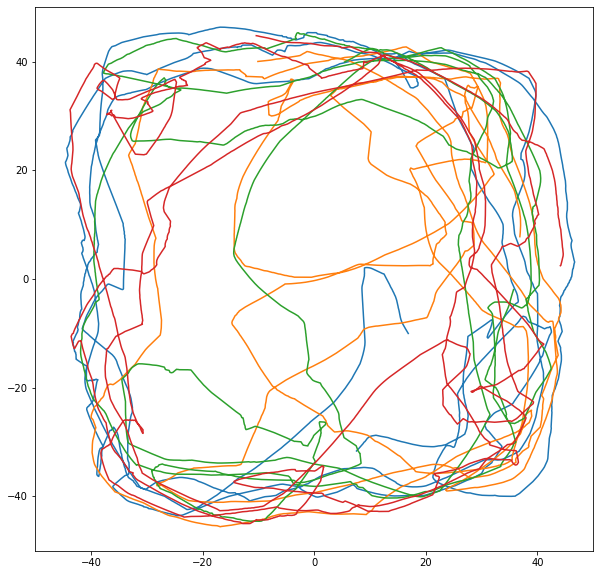

In [100]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [102]:
def trajectory_generator(model_name, model, raycast, dset):
    generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, dset.world_size, dset.frequency
    )
    # Generate raycast file
    # initial_poses = dset.poses[0, :, 0]
    for i in range(20):
        timesteps = 1500
        initial_poses = np.array([[0.0, 0.0, 0.0], [0.0, 3.0, 0.0]])
        track = generator.create_track(2, timesteps, initial_poses=initial_poses)
        f = generator.as_io_file(track)
        f.save_as("output/{}_modeldata/__generated{}.hdf5".format(model_name, str(i)))

In [103]:
trajectory_generator("KNN", model, raycast, dset)

100%|██████████| 1499/1499 [00:19<00:00, 76.20it/s]
